#### Load the initial modules and the data file

In [223]:
import pandas as pd
import numpy as np
np.random.seed(0)

fname = 'Standford_Batch1_CH1.h5'
df = pd.read_hdf(fname)

# print out the column headers
print(df.keys())

# how many cycles are there?
ncycmax = df['Cycle Num'].max()
print('\nnumber of cycles:', ncycmax)

Index(['Cycle Num', 'File Number', 'Test Time (s)', 'Current (Amps)', 'State',
       'Step Time (s)', 'Temperature (C)', 'Internal Resistance',
       'Abs Current (Amps)', 'Step', 'Voltage', 'Index', 'Method'],
      dtype='object')

number of cycles: 1190


#### Let's plot some quantities we may be interested in
Start off with current over the life of the cell

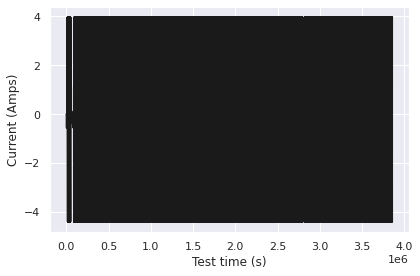

In [200]:
# import plotting module
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# first plot the current over the entire life of the cell
plt.figure(num='current_vs_cycle')
plt.plot(df['Test Time (s)'].values, df['Current (Amps)'].values, 'k-')
plt.xlabel('Test time (s)')
plt.ylabel('Current (Amps)')
plt.tight_layout()

#### Gosh, that's really not helpful
Let's look at cycles 1 through 3 cycles

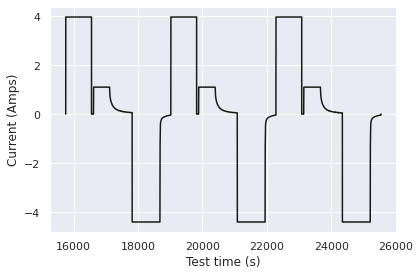

In [201]:
sel = (df['Cycle Num'].values > 0)*(df['Cycle Num'].values < 4)

plt.figure(num='current_vs_cycle_try2')
plt.plot(df['Test Time (s)'].values[sel], df['Current (Amps)'].values[sel], 'k-')
plt.xlabel('Test time (s)')
plt.ylabel('Current (Amps)')
plt.tight_layout()

#### What are we looking at here?
* positive current is for charging
* negative current is for discharging
* zero current is a rest

#### On your own, plot the voltage versus time for cycle 1
#### Take a few mintues to experiment with plotting other quantities as well.

#### open up this cell if you need a hint
<font color='white'>
sel = df['Cycle Num'].values == 1
plt.figure(num='voltage_cycle_1')
plt.plot(df['Test Time (s)'].values[sel], df['Voltage'].values[sel], 'k-')
plt.xlabel('Test time (s)')
plt.ylabel('Voltage')
plt.tight_layout()
</font>

#### Let's extract the maximum discharge capacity of the cell throughout its life

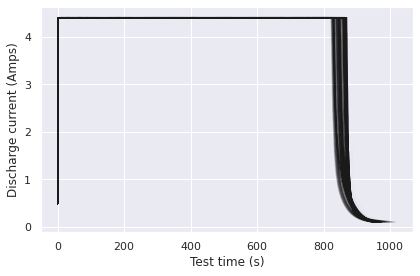

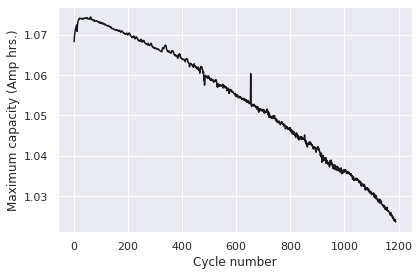

In [203]:
cycs = np.arange(2, ncycmax)
cycs = np.delete(cycs, 10)
Qmaxs = []

plt.figure(num='discharge capacity vs. cycle')
for cyc in cycs:
    sel = (df['Cycle Num'].values == cyc)*(df['Current (Amps)'].values < -0.1)
    t = df['Test Time (s)'].values[sel]
    C = -1*df['Current (Amps)'].values[sel]
    dt = np.diff(t)
    Cmid = (C[1:] + C[:-1])/(2*3600)
    Qmaxs.append(np.sum(dt*Cmid))

    plt.plot(t - t.min(), C, 'k-', alpha=0.01)

plt.xlabel('Test time (s)')
plt.ylabel('Discharge current (Amps)')
plt.tight_layout()
    
plt.figure(num='max capacity vs. cycle')
plt.plot(cycs, Qmaxs, 'k-')
plt.xlabel('Cycle number')
plt.ylabel('Maximum capacity (Amp hrs.)')
plt.tight_layout()

#### Let's extract some features that could help us predict the capacity

Also, let's normalize them and plot them versus cycle

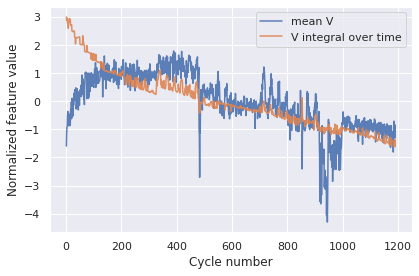

In [204]:
#  define a dictionary of features
# featd = {'cycle number':[], 'mean V':[], 'std V':[],
#          'max 1 pt. V diff.':[], 'max 2 pt. V diff.':[],
#          'V integral over time':[],
#          'CC time':[], 'CV time':[]}

featd = {'mean V':[], 'V integral over time':[]}

# calculate features for each cycles
for cyc in cycs:
    # select the cycle and where the current is negative
    sel = (df['Cycle Num'].values == cyc)*(df['Current (Amps)'].values < -0.1)
    t = df['Test Time (s)'].values[sel]
    C = -1*df['Current (Amps)'].values[sel]
    V = df['Voltage'].values[sel]

    # calculate features
    # featd['cycle number'].append(cyc)
    featd['mean V'].append(V.mean())
    # featd['std V'].append(V.std())
    # featd['max 1 pt. V diff.'].append(np.diff(V).max())
    # featd['max 2 pt. V diff.'].append(np.diff(V, n=2).max())
    dt = np.diff(t)
    Vmid = (V[1:] + V[:-1])/2
    featd['V integral over time'].append(np.sum(dt*Vmid))
    # Cmid = (C[1:] + C[:-1])/2
    # featd['CC time'].append(np.sum(dt[Cmid > 0.99*Cmid.max()]))
    # featd['CV time'].append(np.sum(dt[Vmid < 1.01*Vmid.min()]))
    
# plot all of the features
features = list(featd.keys())
colors = sns.color_palette()[:len(features)]

plt.figure(num='features vs. cycle')
for feature, color in zip(features, colors):
    feats = featd[feature]
    # normalize the features
    feats = (feats - np.mean(feats))/np.std(feats)
    plt.plot(cycs, feats, marker='', ls='-',
        c=color, alpha=0.9, label=feature)
plt.xlabel('Cycle number')
plt.ylabel('Normalized feature value')
plt.legend()
plt.tight_layout()

#### Let's evaluate how these features correlate with the SOH

mean V pearson correlation: 0.771 and p-value: 0.0
V integral over time pearson correlation: 0.928 and p-value: 0.0


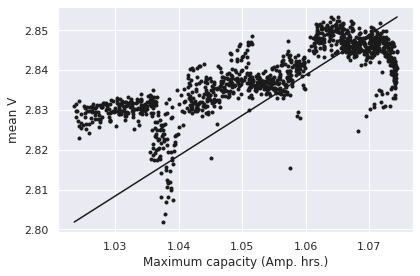

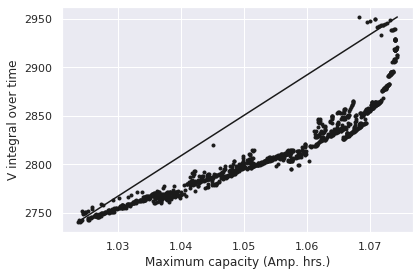

In [205]:
from scipy.stats import pearsonr

for feature in features:
    r, p = pearsonr(featd[feature], Qmaxs)
    print(feature, 'pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
    plt.figure(num=feature + ' correlation')
    feats = featd[feature]
    plt.plot(Qmaxs, feats, 'k.')
    plt.plot([np.min(Qmaxs), np.max(Qmaxs)], [np.min(feats), np.max(feats)], 'k-')
    plt.xlabel('Maximum capacity (Amp. hrs.)')
    plt.ylabel(feature)
    plt.tight_layout()

#### Let's finally develop a very simple machine learning model

The first step is to split our dataset into training, validation, and test sets.

In [206]:
# convert feature dictionary into a Pandas dataframe because it is easier to handle
fdf = pd.DataFrame.from_dict(featd)

# reserve the last 500 cycles for the test set
X_ = fdf.values[:-500, :]
y = np.array(Qmaxs)
y_ = y[:-500]
cycs_ = cycs[:-500]
indx = (np.random.random(size=X_.shape[0]) < 0.8)

X_train = X_[indx, :]
y_train = y_[indx]
cycs_train = cycs_[indx]

X_validate = X_[np.invert(indx), :]
y_validate = y_[np.invert(indx)]
cycs_validate = cycs_[np.invert(indx)]

X_test = fdf.values[-500:, :]
y_test = y[-500:]
cycs_test = cycs[-500:]

print('X_train.shape :', X_train.shape)
print('X_validate.shape :', X_validate.shape)
print('X_test.shape :', X_test.shape)

X_train.shape : (553, 2)
X_validate.shape : (134, 2)
X_test.shape : (500, 2)


Now let's train a model using linear regression and evaluate the results

training pearson correlation: 0.941 and p-value: 0.0
validation pearson correlation: 0.934 and p-value: 0.0
testing pearson correlation: 0.805 and p-value: 0.0
training MAPE: 0.178 %
validation MAPE: 0.189 %
testing MAPE: 0.897 %


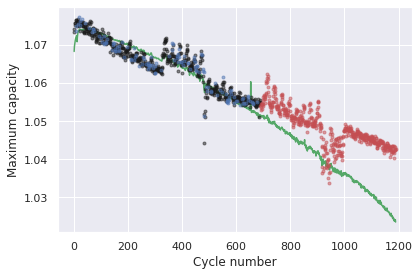

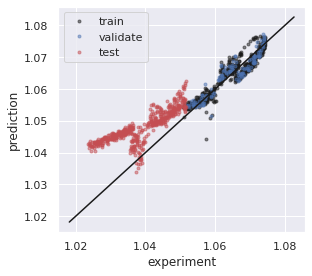

In [207]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
p_train = lr.predict(X_train)
p_validate = lr.predict(X_validate)
p_test = lr.predict(X_test)

r, p = pearsonr(y_train, p_train)
r, p = pearsonr(y_validate, p_validate)

r, p = pearsonr(y_train, p_train)
print('training pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_validate, p_validate)
print('validation pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_test, p_test)
print('testing pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))

mae = np.mean(100*np.abs(y_train - p_train)/y_train)
print('training MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_validate - p_validate)/y_validate)
print('validation MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_test - p_test)/y_test)
print('testing MAPE:', np.round(mae, 3), '%')

plt.figure(num='linear regression SOH prediction')
plt.plot(cycs, y, 'g-', label='SOH')
plt.plot(cycs_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(cycs_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(cycs_test, p_test, 'r.', alpha=0.5, label='test')
plt.xlabel('Cycle number')
plt.ylabel('Maximum capacity')
plt.tight_layout()

plt.figure(num='linear regression parity', figsize=(4.5, 4))
plt.plot(y_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(y_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(y_test, p_test, 'r.', alpha=0.5, label='test')
all_y = list(y_train) + list(p_train) + list(y_validate) + \
    list(p_validate) + list(y_test) + list(p_test)
ymin = np.min(all_y)
ymax = np.max(all_y)
yrng = ymax - ymin
spc = 0.1
plt.plot([ymin-spc*yrng, ymax+spc*yrng],
         [ymin-spc*yrng, ymax+spc*yrng], 'k-')
plt.xlabel('experiment')
plt.ylabel('prediction')
plt.legend()
plt.tight_layout()

Now take 15 or so minutes to experiment with different feature sets and see if you can improve the validation performance. As a hint, look at the voltage and current behavior and see if you can think of features that may correlate well with the SOH.

Next, instead of using an analytical least squares regression approach as before, let's manually define our model and optimize the parameters numerically.

     fun: 0.0030179865980463076
     jac: array([-0.01560853, -0.04443501,  0.00261049])
 message: 'Optimization terminated successfully.'
    nfev: 2603
     nit: 54
 success: True
       x: array([-6.57056820e-01,  4.47667328e-01,  1.57836806e-04])
training pearson correlation: 0.941 and p-value: 0.0
validation pearson correlation: 0.934 and p-value: 0.0
testing pearson correlation: 0.806 and p-value: 0.0
training MAPE: 0.178 %
validation MAPE: 0.189 %
testing MAPE: 0.901 %


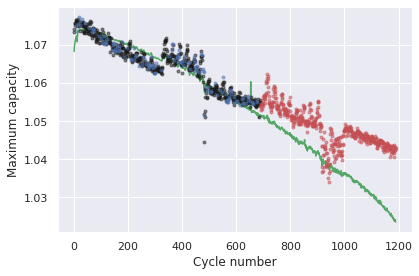

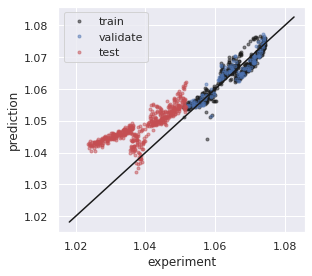

In [208]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

def lin_model(X, params):
    p = params[0]*np.ones(X.shape[0])
    for ii in range(X.shape[1]):
        p += params[ii+1]*X[:, ii]
    return p
        
def cost(X, y, params):
    return np.sum((lin_model(X, params) - y)**2)

def cost_opt(params):
    return cost(X_train, y_train, params)

nparam = X_train.shape[1] + 1
params0 = np.zeros((nparam,))
# res = minimize(cost_opt, params0)
bounds = np.zeros((nparam, 2))
bounds[:, 0] = -1
bounds[:, 1] = 1
res = differential_evolution(cost_opt, bounds)
print(res)
params = res.x

p_train = lin_model(X_train, params)
p_validate = lin_model(X_validate, params)
p_test = lin_model(X_test, params)

r, p = pearsonr(y_train, p_train)
r, p = pearsonr(y_validate, p_validate)

r, p = pearsonr(y_train, p_train)
print('training pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_validate, p_validate)
print('validation pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_test, p_test)
print('testing pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))

mae = np.mean(100*np.abs(y_train - p_train)/y_train)
print('training MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_validate - p_validate)/y_validate)
print('validation MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_test - p_test)/y_test)
print('testing MAPE:', np.round(mae, 3), '%')

plt.figure(num='linear regression SOH prediction v2')
plt.plot(cycs, y, 'g-', label='SOH')
plt.plot(cycs_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(cycs_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(cycs_test, p_test, 'r.', alpha=0.5, label='test')
plt.xlabel('Cycle number')
plt.ylabel('Maximum capacity')
plt.tight_layout()

plt.figure(num='linear regression parity v2', figsize=(4.5, 4))
plt.plot(y_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(y_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(y_test, p_test, 'r.', alpha=0.5, label='test')
all_y = list(y_train) + list(p_train) + list(y_validate) + \
    list(p_validate) + list(y_test) + list(p_test)
ymin = np.min(all_y)
ymax = np.max(all_y)
yrng = ymax - ymin
spc = 0.1
plt.plot([ymin-spc*yrng, ymax+spc*yrng],
         [ymin-spc*yrng, ymax+spc*yrng], 'k-')
plt.xlabel('experiment')
plt.ylabel('prediction')
plt.legend()
plt.tight_layout()

Finally, let's attempt to do a prediciton with a neural network model. Here we are using a simple framework from scikit-learn, but Tensorflow or PyTorch are much more flexible and powerful.

training pearson correlation: 0.879 and p-value: 0.0
validation pearson correlation: 0.878 and p-value: 0.0
testing pearson correlation: 0.965 and p-value: 0.0
training MAPE: 0.494 %
validation MAPE: 0.421 %
testing MAPE: 0.543 %


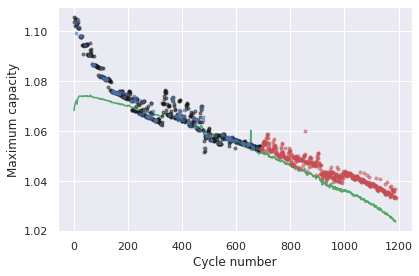

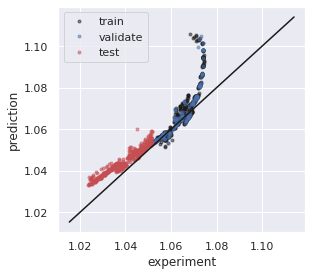

In [221]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000).fit(X_train, y_train)
p_train = nn.predict(X_train)
p_validate = nn.predict(X_validate)
p_test = nn.predict(X_test)

r, p = pearsonr(y_train, p_train)
r, p = pearsonr(y_validate, p_validate)

r, p = pearsonr(y_train, p_train)
print('training pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_validate, p_validate)
print('validation pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))
r, p = pearsonr(y_test, p_test)
print('testing pearson correlation:', np.round(r, 3), 'and p-value:', np.round(p, 3))

mae = np.mean(100*np.abs(y_train - p_train)/y_train)
print('training MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_validate - p_validate)/y_validate)
print('validation MAPE:', np.round(mae, 3), '%')
mae = np.mean(100*np.abs(y_test - p_test)/y_test)
print('testing MAPE:', np.round(mae, 3), '%')

plt.figure(num='linear regression SOH prediction v3')
plt.plot(cycs, y, 'g-', label='SOH')
plt.plot(cycs_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(cycs_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(cycs_test, p_test, 'r.', alpha=0.5, label='test')
plt.xlabel('Cycle number')
plt.ylabel('Maximum capacity')
plt.tight_layout()

plt.figure(num='linear regression parity v3', figsize=(4.5, 4))
plt.plot(y_train, p_train, 'k.', alpha=0.5, label='train')
plt.plot(y_validate, p_validate, 'b.', alpha=0.5, label='validate')
plt.plot(y_test, p_test, 'r.', alpha=0.5, label='test')
all_y = list(y_train) + list(p_train) + list(y_validate) + \
    list(p_validate) + list(y_test) + list(p_test)
ymin = np.min(all_y)
ymax = np.max(all_y)
yrng = ymax - ymin
spc = 0.1
plt.plot([ymin-spc*yrng, ymax+spc*yrng],
         [ymin-spc*yrng, ymax+spc*yrng], 'k-')
plt.xlabel('experiment')
plt.ylabel('prediction')
plt.legend()
plt.tight_layout()